In [23]:
# Imports
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tempfile import TemporaryDirectory
import seaborn as sns
import time
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import numpy as np
import pandas as pd
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(1991)
torch.manual_seed(1991)
torch.cuda.manual_seed(1991)

import random
random.seed(1991)

import numpy as np
np.random.seed(1991)

Running on device: CUDA


In [24]:
# CIFAR 10 dataset
torch.manual_seed(1991)
# Transformations
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# Train data
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
# Train loader
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)

# Test data
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
# Test loader
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
# Add helping dicts
dataloaders = {
    "train": train_loader,
    "val": test_loader
}

dataset_sizes = {"train": len(train_set), "val": len(test_set)}



In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    torch.manual_seed(1991)
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), "best_model_param.pt")
        best_loss = 1000

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train' and scheduler:
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), "best_model_param.pt")

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val loss: {best_loss:4f}')

        # load best model weights
        model.load_state_dict(torch.load("best_model_param.pt"))
    return model


In [40]:
# Train ResNet18
torch.manual_seed(1991)
model_train_reg = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
model_train_reg = model_train_reg.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_train_reg.parameters(), lr=0.001, weight_decay=1e-4)

# Decay LR by a factor of 0.001 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.0005)

In [41]:
from collections import OrderedDict

layer1 = model_train_reg.layer1

for indx in range(len(layer1)):
  modified_layers = OrderedDict()
  for name, feature in layer1[indx].named_children():
    modified_layers[name] = feature
    if isinstance(feature, nn.ReLU):
      modified_layers["dropout"] = nn.Dropout(p=0.3)

  model_train_reg.layer1[indx] = nn.Sequential(modified_layers)



layer2 = model_train_reg.layer2

for indx in [1]:
  modified_layers = OrderedDict()
  for name, feature in layer2[indx].named_children():
    modified_layers[name] = feature
    if isinstance(feature, nn.ReLU):
      modified_layers["dropout"] = nn.Dropout(p=0.3)

  model_train_reg.layer2[indx] = nn.Sequential(modified_layers)

layer3 = model_train_reg.layer3

for indx in [1]:
  modified_layers = OrderedDict()
  for name, feature in layer3[indx].named_children():
    modified_layers[name] = feature
    if isinstance(feature, nn.ReLU):
      modified_layers["dropout"] = nn.Dropout(p=0.3)
  model_train_reg.layer3[indx] = nn.Sequential(modified_layers)

layer4 = model_train_reg.layer4

for indx in [1]:
  modified_layers = OrderedDict()
  for name, feature in layer4[indx].named_children():
    modified_layers[name] = feature
    if isinstance(feature, nn.ReLU):
      modified_layers["dropout"] = nn.Dropout(p=0.3)

  model_train_reg.layer4[indx] = nn.Sequential(modified_layers)

In [42]:
model_train_reg

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Sequential(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [43]:
# Train model Resnet18 21 epochs
model_train_reg = train_model(model_train_reg, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=21)

Epoch 0/20
----------
train Loss: 1.6770 Acc: 0.3788
val Loss: 1.7382 Acc: 0.4151

Epoch 1/20
----------
train Loss: 1.2869 Acc: 0.5349
val Loss: 1.4515 Acc: 0.5036

Epoch 2/20
----------
train Loss: 1.1253 Acc: 0.6010
val Loss: 1.1330 Acc: 0.5996

Epoch 3/20
----------
train Loss: 1.0048 Acc: 0.6472
val Loss: 1.0985 Acc: 0.6200

Epoch 4/20
----------
train Loss: 0.9320 Acc: 0.6718
val Loss: 1.1611 Acc: 0.6055

Epoch 5/20
----------
train Loss: 0.8685 Acc: 0.6979
val Loss: 1.3091 Acc: 0.5950

Epoch 6/20
----------
train Loss: 0.8254 Acc: 0.7138
val Loss: 1.0948 Acc: 0.6441

Epoch 7/20
----------
train Loss: 0.7500 Acc: 0.7387
val Loss: 0.7740 Acc: 0.7328

Epoch 8/20
----------
train Loss: 0.7386 Acc: 0.7420
val Loss: 0.7661 Acc: 0.7367

Epoch 9/20
----------
train Loss: 0.7321 Acc: 0.7456
val Loss: 0.7596 Acc: 0.7379

Epoch 10/20
----------
train Loss: 0.7240 Acc: 0.7485
val Loss: 0.7512 Acc: 0.7399

Epoch 11/20
----------
train Loss: 0.7151 Acc: 0.7517
val Loss: 0.7488 Acc: 0.7414

Ep

In [46]:
torch.save(model_train_reg.state_dict(), "cifar10_resnet18_l2_dropout_regularization.pt")

In [44]:
model_train_reg.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Sequential(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [45]:

# Check accuracy

def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for i, (inputs, targets) in enumerate(loader, 0):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model_train_reg, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model_train_reg, test_loader):0.1f}%")

Train set accuracy: 79.1%
Test set accuracy: 74.4%


In [47]:

df_dict = {
    "label": [],
    "last_conv_layer": [],
    "train": [],
    "loss": []
}

In [48]:
total_num = 0
criterion = nn.CrossEntropyLoss(reduction="none")
for i, batch in enumerate(train_loader, 0):
  images, labels = batch
  images = images.to(DEVICE)
  for image, label in zip(images, labels):
    logits = model_train_reg(image.unsqueeze(0))
    total_num += 1
    losses = criterion(logits, label.unsqueeze(0).to(DEVICE)).numpy(force=True)

    df_dict["loss"].append(losses[0])
    df_dict["label"].append(label)
    df_dict["train"].append("Тренувальний набір")
    if total_num >= 10000:
      break
  if total_num >= 10000:
    break

In [49]:

total_num = 0
for i, batch in enumerate(test_loader, 0):
  images, labels = batch
  images = images.to(DEVICE)
  for image, label in zip(images, labels):
    logits = model_train_reg(image.unsqueeze(0))
    total_num += 1
    losses = criterion(logits, label.unsqueeze(0).to(DEVICE)).numpy(force=True)

    df_dict["loss"].append(losses[0])
    df_dict["label"].append(label)
    df_dict["train"].append("Тестовий набір")

In [50]:
df = pd.DataFrame.from_dict({
    "train": df_dict["train"],
    "loss": df_dict["loss"]
})


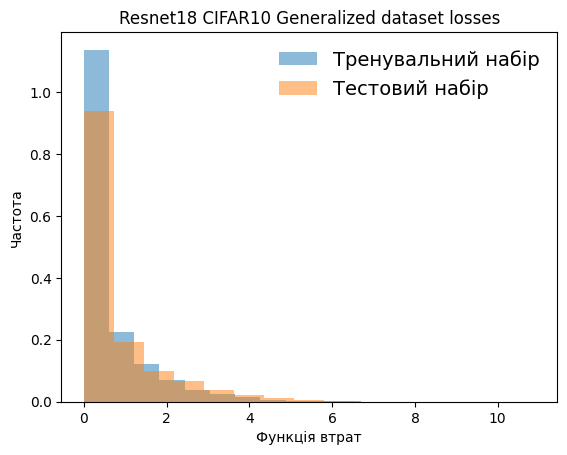

In [51]:
plt.title(f"Resnet18 CIFAR10 Generalized dataset losses")
plt.hist(df.loc[df["train"] == "Тренувальний набір"]["loss"], density=True, alpha=0.5, bins=15, label="Тренувальний набір")
plt.hist(df.loc[df["train"] == "Тестовий набір"]["loss"], density=True, alpha=0.5, bins=15, label="Тестовий набір")

plt.ylabel("Частота")
plt.xlabel("Функція втрат")
plt.legend(frameon=False, fontsize=14)
plt.show()

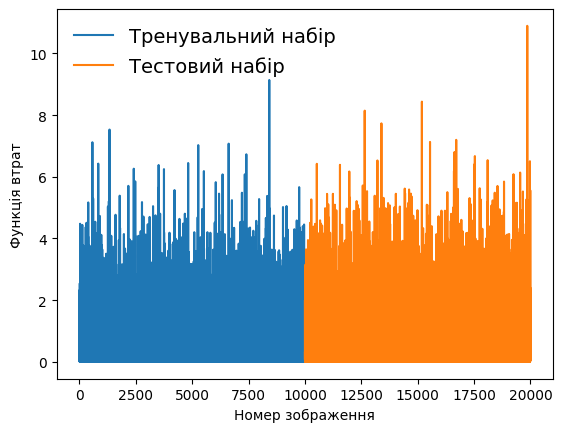

In [52]:
plt.plot(df.loc[df["train"] == "Тренувальний набір"]["loss"], label="Тренувальний набір")
plt.plot(df.loc[df["train"] == "Тестовий набір"]["loss"], label="Тестовий набір")

plt.ylabel("Функція втрат")
plt.xlabel("Номер зображення")
plt.legend(frameon=False, fontsize=14)
plt.show()


In [18]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [22]:
# model_train_reg = model_train_reg.to(DEVICE)
# model_train_reg = model_train_reg.eval()
torch.save(model_train_reg.state_dict(), "new.pt")

model = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
model = model.to(DEVICE)

optimizer_ft = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# model.eval()
model.load_state_dict(torch.load("new.pt", map_location=DEVICE), strict=True)
# model_BETA = model.to(DEVICE)

# model_train_reg = model_train_reg.to("cpu")

model.conv1.register_forward_hook(get_activation('c11'))
model_train_reg.conv1.register_forward_hook(get_activation('c12'))

model.bn1.register_forward_hook(get_activation('bn1_1'))
model_train_reg.bn1.register_forward_hook(get_activation('bn1_2'))

model.relu.register_forward_hook(get_activation('relu1'))
model_train_reg.relu.register_forward_hook(get_activation('relu2'))


model.maxpool.register_forward_hook(get_activation('maxpool1'))
model_train_reg.maxpool.register_forward_hook(get_activation('maxpool2'))

# model.layer1[0].conv1.register_forward_hook(get_activation('layer11'))
# model_train_reg.layer1[0].conv1.register_forward_hook(get_activation('layer12'))

model.layer1[0].conv1.register_forward_hook(get_activation('layer11c'))
model_train_reg.layer1[0].conv1.register_forward_hook(get_activation('layer12c'))

model.layer1[0].bn1.register_forward_hook(get_activation('layer11bn1'))
model_train_reg.layer1[0].bn1.register_forward_hook(get_activation('layer12bn1'))

model.layer1[0].relu.register_forward_hook(get_activation('layer11relu1'))
model_train_reg.layer1[0].relu.register_forward_hook(get_activation('layer12relu1'))


model.eval()
model_train_reg.eval()

with torch.no_grad():
  for i, (inputs, targets) in enumerate(train_loader, 0):
    inputs = inputs.to(DEVICE)
    outputs1 = model_train_reg(inputs[0].unsqueeze(0))
    outputs2 = model(inputs[0].unsqueeze(0))
    print(outputs1[0])
    print(outputs2[0])
    break


(activation['layer12relu1'] == activation['layer11relu1']).all()

tensor([-2.0903, -0.0847, -1.3792, -1.1936,  1.9133,  2.7130, -1.4941, 11.3645,
        -4.7467, -1.8557], device='cuda:0')
tensor([-0.0757, -0.5074, -0.6683,  1.8993, -0.9555,  1.2442, -1.2682,  2.2061,
        -1.1451, -0.6048], device='cuda:0')


tensor(False, device='cuda:0')

In [12]:
ac1 = activation['layer12relu1']